In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [3]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [4]:
# structures = ['7N', '12N']
# labels_to_sample = structures + map(convert_to_surround_name, structures)
# labels_to_sample = structures + [convert_to_surround_name(l, surr_l) for l in structures for surr_l in structures + ['noclass'] if surr_l != l]
# labels_to_sample = structures + [l + '_negative' for l in structures]
labels_to_sample = structures + [l + '_negative' for l in structures] + \
[convert_to_surround_name(l, margin=m, suffix=surr_l) for m in [100,200,300,400,500,600,700,800,900,1000]
 for l in structures for surr_l in structures + ['noclass'] if surr_l != l] + \
['noclass']

# Training

In [8]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels = set([])

# for stack in ['MD589', 'MD585', 'MD594']:
for stack in ['MD635']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, num_samples_per_landmark=1000)
    
    for name_u, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

In [5]:
# Optional, if no need to sample training patches

labels = set([])

# for stack in ['MD589', 'MD585', 'MD594']:
for stack in ['MD635']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack

In [6]:
existing_names = set([convert_to_original_name(l) for l in labels]) - {'noclass'}

In [65]:
# See if we can use location on image frame as feature

# def addresses_to_locations(addresses):
    
#     key_func = lambda (i, (st, se, idx)): st
    
#     locations = []
    
#     for stack, group in groupby(sorted(enumerate(addresses), key=key_func), key=key_func):
#         sample_locations = grid_parameters_to_sample_locations(get_default_gridspec(stack))
#         for i, (st, se, idx) in group:
#             locations.append((i, sample_locations[idx]))
    
#     return [loc for i, loc in sorted(locations)]

In [66]:
# locations = np.array(addresses_to_locations(training_addresses['10N']))

# plt.scatter(locations[:,0], locations[:,1]);
# plt.xlim([0, 15000]);
# plt.ylim([0, 12000]);

In [76]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

('MD635', 75)
('MD635', 76)
('MD635', 77)


Patch in annotation but not in mask: MD635 77 MD635-F26-2016.05.18-21.16.59_MD635_2_0077 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @164


('MD635', 78)
('MD635', 79)
('MD635', 80)
('MD635', 81)
('MD635', 82)


Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30782
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30029
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @31786


('MD635', 83)
('MD635', 84)
('MD635', 85)
('MD635', 86)
('MD635', 87)


Patch in annotation but not in mask: MD635 87 MD635-F29-2016.05.18-22.01.14_MD635_3_0087 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @191


('MD635', 88)
('MD635', 89)
('MD635', 90)
('MD635', 91)


Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @203
Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @200


('MD635', 92)


Patch in annotation but not in mask: MD635 92 MD635-F31-2016.05.18-22.31.18_MD635_2_0092 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @98


('MD635', 94)
('MD635', 95)


Patch in annotation but not in mask: MD635 95 MD635-F32-2016.05.18-22.50.16_MD635_2_0095 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @170


('MD635', 96)
('MD635', 97)
('MD635', 98)
('MD635', 99)
('MD635', 100)
('MD635', 101)


Patch in annotation but not in mask: MD635 101 MD635-F34-2016.05.18-23.23.55_MD635_2_0101 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @176


('MD635', 102)


Patch in annotation but not in mask: MD635 102 MD635-F34-2016.05.18-23.23.55_MD635_3_0102 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @63
Patch in annotation but not in mask: MD635 102 MD635-F34-2016.05.18-23.23.55_MD635_3_0102 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @159


('MD635', 103)


Patch in annotation but not in mask: MD635 103 MD635-F35-2016.05.18-23.40.52_MD635_1_0103 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @121


('MD635', 104)


Patch in annotation but not in mask: MD635 104 MD635-F35-2016.05.18-23.40.52_MD635_2_0104 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @226


('MD635', 105)
('MD635', 106)
('MD635', 107)
('MD635', 108)
('MD635', 109)


Patch in annotation but not in mask: MD635 109 MD635-F37-2016.05.23-14.05.18_MD635_1_0109 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @25


('MD635', 110)
('MD635', 111)
('MD635', 112)
('MD635', 113)
('MD635', 114)


Patch in annotation but not in mask: MD635 114 MD635-F38-2016.05.19-00.34.28_MD635_3_0114 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @69


('MD635', 115)
('MD635', 116)
('MD635', 117)


Patch in annotation but not in mask: MD635 117 MD635-F39-2016.05.19-00.52.10_MD635_3_0117 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @42


('MD635', 118)


Patch in annotation but not in mask: MD635 118 MD635-F40-2016.05.19-01.08.51_MD635_1_0118 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @100


('MD635', 119)
('MD635', 120)
('MD635', 121)
('MD635', 122)
('MD635', 123)
('MD635', 124)
('MD635', 125)
('MD635', 126)
('MD635', 127)


Patch in annotation but not in mask: MD635 127 MD635-F43-2016.05.19-02.06.14_MD635_1_0127 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @144


('MD635', 128)
('MD635', 129)
('MD635', 130)
('MD635', 131)
('MD635', 132)
('MD635', 133)
('MD635', 134)
('MD635', 135)
('MD635', 136)
('MD635', 137)


Patch in annotation but not in mask: MD635 137 MD635-F46-2016.05.19-03.02.11_MD635_2_0137 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @68


('MD635', 138)
('MD635', 139)


Patch in annotation but not in mask: MD635 139 MD635-F47-2016.05.19-03.19.48_MD635_1_0139 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @103


('MD635', 140)


Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @42856
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41598


('MD635', 141)


Patch in annotation but not in mask: MD635 141 MD635-F47-2016.05.19-03.19.48_MD635_3_0141 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @24
Patch in annotation but not in mask: MD635 141 MD635-F47-2016.05.19-03.19.48_MD635_3_0141 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @92


('MD635', 142)


Patch in annotation but not in mask: MD635 142 MD635-F48-2016.05.19-03.40.12_MD635_1_0142 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @132


('MD635', 143)


Patch in annotation but not in mask: MD635 143 MD635-F48-2016.05.19-03.40.12_MD635_2_0143 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @131


('MD635', 144)
('MD635', 145)


Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41


('MD635', 146)


Patch in annotation but not in mask: MD635 146 MD635-F49-2016.05.19-03.59.43_MD635_2_0146 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @188
Patch in annotation but not in mask: MD635 146 MD635-F49-2016.05.19-03.59.43_MD635_2_0146 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @204
Patch in annotation but not in mask: MD635 146 MD635-F49-2016.05.19-03.59.43_MD635_2_0146 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @58
Patch in annotation but not in mask: MD635 146 MD635-F49-2016.05.19-03.59.43_MD635_2_0146 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @101


('MD635', 147)


Patch in annotation but not in mask: MD635 147 MD635-F49-2016.05.23-14.25.13_MD635_3_0147 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @90


('MD635', 148)
('MD635', 149)


Patch in annotation but not in mask: MD635 149 MD635-F50-2016.05.23-14.45.07_MD635_2_0149 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @183


('MD635', 150)


Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @217
Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @33


('MD635', 151)
('MD635', 152)
('MD635', 153)


Patch in annotation but not in mask: MD635 153 MD635-F51-2016.05.23-15.04.39_MD635_3_0153 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @173


('MD635', 154)
('MD635', 155)
('MD635', 156)
('MD635', 157)


Patch in annotation but not in mask: MD635 157 MD635-F53-2016.05.23-15.42.22_MD635_1_0157 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @137


('MD635', 158)
('MD635', 159)
('MD635', 160)
('MD635', 161)


Patch in annotation but not in mask: MD635 161 MD635-F54-2016.05.19-05.34.49_MD635_3_0162 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21


('MD635', 162)


Patch in annotation but not in mask: MD635 162 MD635-F55-2016.05.19-05.55.53_MD635_2_0164 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @147


('MD635', 163)
('MD635', 164)


Patch in annotation but not in mask: MD635 164 MD635-F56-2016.05.19-06.13.54_MD635_1_0166 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @128


('MD635', 165)
('MD635', 166)


Patch in annotation but not in mask: MD635 166 MD635-F57-2016.05.19-06.32.00_MD635_1_0169 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @47
Patch in annotation but not in mask: MD635 166 MD635-F57-2016.05.19-06.32.00_MD635_1_0169 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @130
Patch in annotation but not in mask: MD635 166 MD635-F57-2016.05.19-06.32.00_MD635_1_0169 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @189


('MD635', 167)


Patch in annotation but not in mask: MD635 167 MD635-F57-2016.05.19-06.32.00_MD635_2_0170 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @56


('MD635', 168)
('MD635', 169)


Patch in annotation but not in mask: MD635 169 MD635-F58-2016.05.19-06.52.57_MD635_2_0173 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @221
Patch in annotation but not in mask: MD635 169 MD635-F58-2016.05.19-06.52.57_MD635_2_0173 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @19


('MD635', 170)


Patch in annotation but not in mask: MD635 170 MD635-F59-2016.05.19-07.14.24_MD635_1_0175 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @44


('MD635', 171)


Patch in annotation but not in mask: MD635 171 MD635-F59-2016.05.19-07.14.24_MD635_2_0176 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30


('MD635', 172)
('MD635', 173)


Patch in annotation but not in mask: MD635 173 MD635-F60-2016.05.19-07.35.14_MD635_2_0179 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @99
Patch in annotation but not in mask: MD635 173 MD635-F60-2016.05.19-07.35.14_MD635_2_0179 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @44


('MD635', 174)


Patch in annotation but not in mask: MD635 174 MD635-F61-2016.05.19-07.56.43_MD635_1_0181 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @198


('MD635', 175)
('MD635', 176)


Patch in annotation but not in mask: MD635 176 MD635-F62-2016.05.19-08.18.25_MD635_1_0184 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @19


('MD635', 177)


Patch in annotation but not in mask: MD635 177 MD635-F62-2016.05.19-08.18.25_MD635_2_0185 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @47
Patch in annotation but not in mask: MD635 177 MD635-F62-2016.05.19-08.18.25_MD635_2_0185 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @50


('MD635', 178)


Patch in annotation but not in mask: MD635 178 MD635-F63-2016.05.19-08.39.03_MD635_1_0187 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @39


('MD635', 179)


Patch in annotation but not in mask: MD635 179 MD635-F63-2016.05.19-08.39.03_MD635_2_0188 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @44


('MD635', 180)
('MD635', 181)
('MD635', 182)
('MD635', 183)
('MD635', 184)
('MD635', 185)
('MD635', 186)
('MD635', 187)


Patch in annotation but not in mask: MD635 187 MD635-F67-2016.05.19-09.59.06_MD635_2_0200 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @196


('MD635', 188)


Patch in annotation but not in mask: MD635 188 MD635-F68-2016.05.19-10.18.40_MD635_1_0202 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @215


('MD635', 189)
('MD635', 190)


Patch in annotation but not in mask: MD635 190 MD635-F69-2016.05.19-10.38.34_MD635_1_0205 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @163
Patch in annotation but not in mask: MD635 190 MD635-F69-2016.05.19-10.38.34_MD635_1_0205 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @43


('MD635', 191)
('MD635', 192)


Patch in annotation but not in mask: MD635 192 MD635-F70-2016.05.19-10.57.59_MD635_1_0208 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @162
Patch in annotation but not in mask: MD635 192 MD635-F70-2016.05.19-10.57.59_MD635_1_0208 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @173


('MD635', 193)


Patch in annotation but not in mask: MD635 193 MD635-F70-2016.05.19-10.57.59_MD635_2_0209 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @174


('MD635', 194)
('MD635', 195)


Patch in annotation but not in mask: MD635 195 MD635-F71-2016.05.19-11.17.07_MD635_2_0212 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @121


('MD635', 196)


Patch in annotation but not in mask: MD635 196 MD635-F72-2016.05.19-11.37.07_MD635_1_0214 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @125


('MD635', 197)


Patch in annotation but not in mask: MD635 197 MD635-F72-2016.05.19-11.37.07_MD635_2_0215 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @172


('MD635', 198)
('MD635', 199)


Patch in annotation but not in mask: MD635 199 MD635-F73-2016.05.19-11.56.44_MD635_2_0218 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @120


('MD635', 200)


Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @19778
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21288
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @22542
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @22295
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20532
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21786
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo 

('MD635', 201)
('MD635', 202)
('MD635', 203)


Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @84
Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @224
Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @133
Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30


('MD635', 204)


Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @88


('MD635', 206)


Patch in annotation but not in mask: MD635 206 MD635-F77-2016.05.19-13.07.42_MD635_1_0229 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @86
Patch in annotation but not in mask: MD635 206 MD635-F77-2016.05.19-13.07.42_MD635_1_0229 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @217
Patch in annotation but not in mask: MD635 206 MD635-F77-2016.05.19-13.07.42_MD635_1_0229 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @176


('MD635', 207)


Patch in annotation but not in mask: MD635 207 MD635-F77-2016.05.19-13.07.42_MD635_2_0230 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @211


('MD635', 208)
('MD635', 209)
('MD635', 210)
('MD635', 211)
('MD635', 212)
('MD635', 213)


Patch in annotation but not in mask: MD635 213 MD635-F80-2016.05.19-14.03.50_MD635_2_0239 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @77


('MD635', 214)
('MD635', 216)
('MD635', 217)


Patch in annotation but not in mask: MD635 217 MD635-F82-2016.05.19-14.39.57_MD635_2_0245 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @31
Patch in annotation but not in mask: MD635 217 MD635-F82-2016.05.19-14.39.57_MD635_2_0245 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @151


('MD635', 218)


Patch in annotation but not in mask: MD635 218 MD635-F83-2016.05.19-14.59.24_MD635_1_0247 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @231


('MD635', 219)
('MD635', 220)
('MD635', 221)


Patch in annotation but not in mask: MD635 221 MD635-F84-2016.05.19-15.18.11_MD635_2_0251 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @105


('MD635', 222)
('MD635', 223)


Patch in annotation but not in mask: MD635 223 MD635-F85-2016.05.19-15.36.47_MD635_2_0254 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @217


('MD635', 224)
('MD635', 225)
('MD635', 226)
('MD635', 227)


Patch in annotation but not in mask: MD635 227 MD635-F87-2016.05.19-16.15.25_MD635_2_0260 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @84


('MD635', 228)
('MD635', 229)


Patch in annotation but not in mask: MD635 229 MD635-F88-2016.05.19-16.34.48_MD635_2_0263 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @217


('MD635', 230)


Patch in annotation but not in mask: MD635 230 MD635-F89-2016.05.19-16.53.54_MD635_1_0265 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @221


('MD635', 231)


Patch in annotation but not in mask: MD635 231 MD635-F89-2016.05.19-16.53.54_MD635_2_0266 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @33


('MD635', 233)


Patch in annotation but not in mask: MD635 233 MD635-F90-2016.05.19-17.14.09_MD635_2_0269 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @58
Patch in annotation but not in mask: MD635 233 MD635-F90-2016.05.19-17.14.09_MD635_2_0269 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @54


('MD635', 234)


Patch in annotation but not in mask: MD635 234 MD635-F91-2016.05.19-17.33.31_MD635_1_0271 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @161


('MD635', 235)
('MD635', 236)


Patch in annotation but not in mask: MD635 236 MD635-F92-2016.05.19-17.52.45_MD635_1_0274 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @168


('MD635', 237)


Patch in annotation but not in mask: MD635 237 MD635-F92-2016.05.19-17.52.45_MD635_2_0275 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @23
Patch in annotation but not in mask: MD635 237 MD635-F92-2016.05.19-17.52.45_MD635_2_0275 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @60


('MD635', 238)


Patch in annotation but not in mask: MD635 238 MD635-F93-2016.05.19-18.12.24_MD635_1_0277 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @116


('MD635', 239)
('MD635', 240)


In [77]:
training_features = {name: np.array([f for f in feats if f is not None]) 
                     for name, feats in training_features.iteritems()}

In [78]:
for name in sorted(training_features.iterkeys()):
    print name, len(training_features[name])

10N 1000
10N_negative 998
10N_surround_12N 1000
10N_surround_AP 76
10N_surround_noclass 1000
12N 1000
12N_negative 995
12N_surround_10N 1000
12N_surround_AP 106
12N_surround_noclass 1000
5N 1000
5N_negative 998
5N_surround_noclass 1000
6N 496
6N_negative 997
6N_surround_7n 101
6N_surround_noclass 1000
7N 998
7N_negative 997
7N_surround_7n 110
7N_surround_noclass 1000
7n 1000
7n_negative 997
7n_surround_6N 125
7n_surround_7N 108
7n_surround_noclass 1000
AP 923
AP_negative 993
AP_surround_10N 58
AP_surround_12N 142
AP_surround_noclass 1000
DC 1000
DC_negative 997
DC_surround_VCA 888
DC_surround_VCP 981
DC_surround_noclass 1000
IC 1000
IC_negative 994
IC_surround_SC 1000
IC_surround_noclass 1000
LC 1000
LC_negative 999
LC_surround_noclass 1000
Pn 992
Pn_negative 994
Pn_surround_RtTg 1000
Pn_surround_Tz 5
Pn_surround_noclass 1000
RtTg 1000
RtTg_negative 996
RtTg_surround_Pn 1000
RtTg_surround_Tz 470
RtTg_surround_noclass 1000
SC 1000
SC_negative 998
SC_surround_IC 1000
SC_surround_noclass 

In [81]:
# Save training features

train_feat_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'training_features/'))

for name_u, feats in training_features.iteritems():
#     bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name_u + '_trainSampleScheme_%d.bp' % train_sample_scheme))
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name_u + '.bp'))

In [7]:
# Load training features

# training_features = {name_u: bp.unpack_ndarray_file(os.path.join(SVM_NTBLUE_ROOTDIR, 'training_features', \
#                                  name_u + '_trainSampleScheme_%d.bp' % train_sample_scheme))
#                      for name_u in labels}

training_features = {name_u: bp.unpack_ndarray_file(os.path.join(SVM_NTBLUE_ROOTDIR, 'training_features', \
                                 name_u + '.bp'))
                     for name_u in labels}

In [7]:
# negatives are surrounding patches that are not of other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 1

# negatives are surrounding patches that include other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 2

# negatives are surrounding patches that are not of other positive classes
# SVC(kernel='linear')
# train_sample_scheme = 3

# negatives are surrounding patches that are not of other positive classes
# LinearSVC(kernel='linear') + CalibratedClassifierCV
# train_sample_scheme = 4

# negatives are surrounding patches that are not of other positive classes
# XGBClassifier
# train_sample_scheme = 5

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=3, n_estimators=200
# train_sample_scheme = 6

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=5, n_estimators=100
# train_sample_scheme = 7

# negatives are all outside patches
# LogisticRegression(penalty='l2')
train_sample_scheme = 8

In [9]:
# train svm classifiers

if stack in ['MD635']:
    svm_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'classifiers'))
else:
    svm_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'classifiers'))

# for label in structures:
for label in existing_names:
            
    print label

    t = time.time()

    features_pos = training_features[label]
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        features_neg = training_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([training_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [training_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    elif train_sample_scheme == 8:
        features_neg = training_features[label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')
   
    train_data0 = np.r_[features_pos, features_neg]
    train_labels0 = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

    train_data = train_data0
    train_labels = train_labels0
    
#     svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)

    if train_sample_scheme in [1, 8]:
        # 1 - L2 penalty - train: 0.88, test acc: 0.84
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 2:
        # L1 penalty - test acc: 0.818
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

            
    elif train_sample_scheme == 3:
        # Slow - train acc: 0.69, test acc: 0.68
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})


    elif train_sample_scheme == 4:
        # train 0.75, test 0.74
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

        
    elif train_sample_scheme == 5:
        # train 
        
        # http://xgboost.readthedocs.io/en/latest/python/python_api.html
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(svc, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 6:
        # acc: 0.96/0.85
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif train_sample_scheme == 7:
        # acc: 0.98/0.87
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('training scheme is not recognized.\n')
 
    sys.stderr.write('train classifier: %.2f seconds\n' % (time.time() - t))
    
    
    # TODO: specify sample weights
    
    clf.fit(train_data, train_labels)
#     clf.fit(train_data, train_labels, sample_weight=sample_weight)
    
    joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})
        
#     del features_pos, features_neg, train_data, train_labels, svc

RtTg


train classifier: 0.01 seconds


VCA


train classifier: 0.00 seconds


10N


train classifier: 0.00 seconds


VLL


train classifier: 0.01 seconds


7n


train classifier: 0.00 seconds


SNC


train classifier: 0.00 seconds


Sp5C


train classifier: 0.00 seconds


12N


train classifier: 0.00 seconds


DC


train classifier: 0.00 seconds


VCP


train classifier: 0.00 seconds


AP


train classifier: 0.00 seconds


5N


train classifier: 0.00 seconds


SNR


train classifier: 0.00 seconds


6N


train classifier: 0.00 seconds


7N


train classifier: 0.00 seconds


SC


train classifier: 0.00 seconds


Tz


train classifier: 0.00 seconds


IC


train classifier: 0.00 seconds


Pn


train classifier: 0.00 seconds


LC


train classifier: 0.01 seconds


# Load pre-computed svm classifiers

In [8]:
svc_allClasses = {}
# for label in structures:
for label in existing_names:
    if stack in ['MD635']: # neurotrace blue stacks
        svc_allClasses[label] = joblib.load(SVM_NTBLUE_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})
    else: # regular Nissl
        svc_allClasses[label] = joblib.load(SVM_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

In [34]:
# visualize training patches

In [ ]:
patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')

In [ ]:
display_images_in_grids(patches, 5)

In [ ]:
patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')

In [ ]:
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

In [ ]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

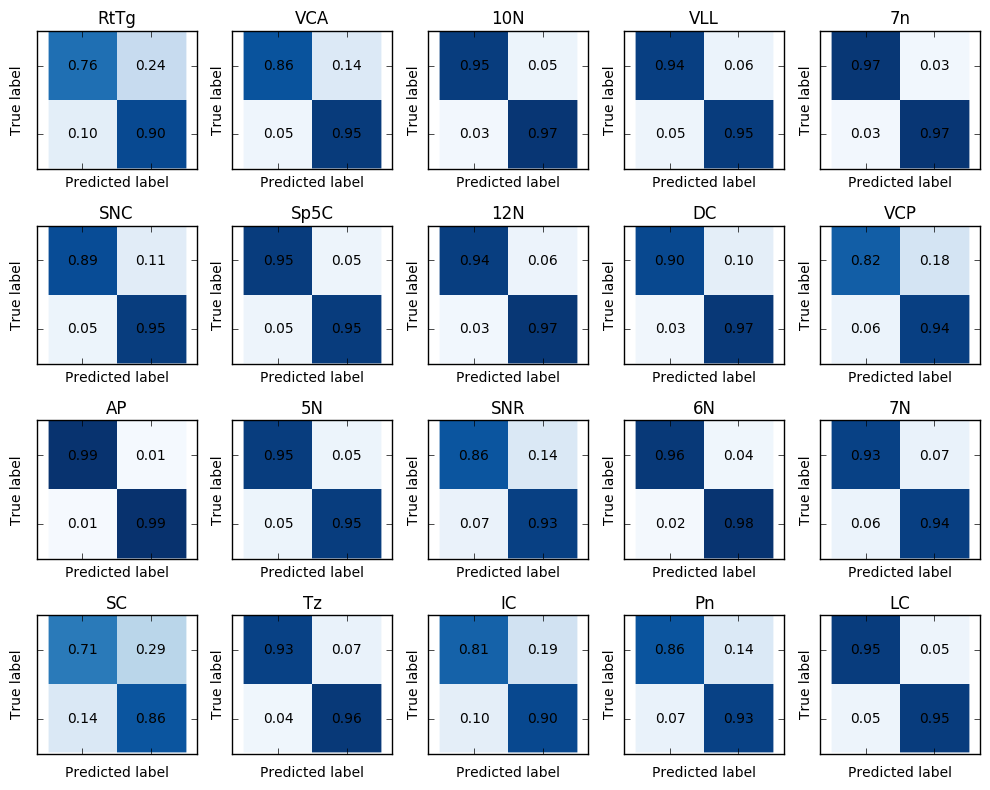

In [11]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = training_features[label]
    
    if train_sample_scheme in [1,3,4,5,6,7]:
        features_neg = training_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([training_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [training_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    elif train_sample_scheme == 8:
        features_neg = training_features[label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[label] = .5 * (cm[0,0] + cm[1,1])
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [12]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.921448135282


# Test

In [10]:
if stack in ['MD635']:
    test_feat_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'test_features'))
else:
    test_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'test_features'))

In [16]:
# Extract test samples

test_addresses = defaultdict(list)

# for stack in ['MD589', 'MD585', 'MD594']:
for stack in ['MD635']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    sampled_addresses_sec_idx = sample_locations(label_gridIndices, labels, num_samples_per_landmark=1000)
    
    for name_u, addresses in sampled_addresses_sec_idx.iteritems():
        test_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
test_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

In [17]:
test_features = apply_function_to_dict(addresses_to_features, test_addresses)

('MD635', 75)
('MD635', 76)
('MD635', 77)
('MD635', 78)
('MD635', 79)
('MD635', 80)


Patch in annotation but not in mask: MD635 80 MD635-F27-2016.05.18-21.31.38_MD635_2_0080 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @218


('MD635', 81)
('MD635', 82)


Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30531
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @34545


('MD635', 83)
('MD635', 84)
('MD635', 85)
('MD635', 86)
('MD635', 87)
('MD635', 88)


Patch in annotation but not in mask: MD635 88 MD635-F30-2016.05.18-22.15.39_MD635_1_0088 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @155
Patch in annotation but not in mask: MD635 88 MD635-F30-2016.05.18-22.15.39_MD635_1_0088 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @44


('MD635', 89)


Patch in annotation but not in mask: MD635 89 MD635-F30-2016.05.18-22.15.39_MD635_2_0089 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @68


('MD635', 90)
('MD635', 91)


Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @88


('MD635', 92)


Patch in annotation but not in mask: MD635 92 MD635-F31-2016.05.18-22.31.18_MD635_2_0092 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @151


('MD635', 94)


Patch in annotation but not in mask: MD635 94 MD635-F32-2016.05.18-22.50.16_MD635_1_0094 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @229


('MD635', 95)
('MD635', 96)
('MD635', 97)
('MD635', 98)
('MD635', 99)


Patch in annotation but not in mask: MD635 99 MD635-F33-2016.05.18-23.06.34_MD635_3_0099 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @128


('MD635', 100)


Patch in annotation but not in mask: MD635 100 MD635-F34-2016.05.18-23.23.55_MD635_1_0100 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @177
Patch in annotation but not in mask: MD635 100 MD635-F34-2016.05.18-23.23.55_MD635_1_0100 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @220


('MD635', 101)
('MD635', 102)


Patch in annotation but not in mask: MD635 102 MD635-F34-2016.05.18-23.23.55_MD635_3_0102 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @130


('MD635', 103)
('MD635', 104)
('MD635', 105)


Patch in annotation but not in mask: MD635 105 MD635-F35-2016.05.18-23.40.52_MD635_3_0105 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @124


('MD635', 106)
('MD635', 107)
('MD635', 108)
('MD635', 109)


Patch in annotation but not in mask: MD635 109 MD635-F37-2016.05.23-14.05.18_MD635_1_0109 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @160


('MD635', 110)
('MD635', 111)
('MD635', 112)


Patch in annotation but not in mask: MD635 112 MD635-F38-2016.05.19-00.34.28_MD635_1_0112 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @229


('MD635', 113)
('MD635', 114)


Patch in annotation but not in mask: MD635 114 MD635-F38-2016.05.19-00.34.28_MD635_3_0114 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @197


('MD635', 115)


Patch in annotation but not in mask: MD635 115 MD635-F39-2016.05.19-00.52.10_MD635_1_0115 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @230


('MD635', 116)
('MD635', 117)


Patch in annotation but not in mask: MD635 117 MD635-F39-2016.05.19-00.52.10_MD635_3_0117 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @228
Patch in annotation but not in mask: MD635 117 MD635-F39-2016.05.19-00.52.10_MD635_3_0117 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @24


('MD635', 118)
('MD635', 119)


Patch in annotation but not in mask: MD635 119 MD635-F40-2016.05.19-01.08.51_MD635_2_0119 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @220


('MD635', 120)


Patch in annotation but not in mask: MD635 120 MD635-F40-2016.05.19-01.08.51_MD635_3_0120 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @106


('MD635', 121)
('MD635', 122)
('MD635', 123)
('MD635', 124)
('MD635', 125)
('MD635', 126)
('MD635', 127)
('MD635', 128)
('MD635', 129)
('MD635', 130)
('MD635', 131)
('MD635', 132)
('MD635', 133)
('MD635', 134)
('MD635', 135)
('MD635', 136)
('MD635', 137)
('MD635', 138)


Patch in annotation but not in mask: MD635 138 MD635-F46-2016.05.19-03.02.11_MD635_3_0138 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @135
Patch in annotation but not in mask: MD635 138 MD635-F46-2016.05.19-03.02.11_MD635_3_0138 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @170


('MD635', 139)
('MD635', 140)


Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41851
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @42602
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41603
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @42101
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41602
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41351


('MD635', 141)


Patch in annotation but not in mask: MD635 141 MD635-F47-2016.05.19-03.19.48_MD635_3_0141 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @110
Patch in annotation but not in mask: MD635 141 MD635-F47-2016.05.19-03.19.48_MD635_3_0141 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @179


('MD635', 142)
('MD635', 143)
('MD635', 144)


Patch in annotation but not in mask: MD635 144 MD635-F48-2016.05.19-03.40.12_MD635_3_0144 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @155
Patch in annotation but not in mask: MD635 144 MD635-F48-2016.05.19-03.40.12_MD635_3_0144 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @80
Patch in annotation but not in mask: MD635 144 MD635-F48-2016.05.19-03.40.12_MD635_3_0144 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @73


('MD635', 145)


Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @132
Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @44
Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @135


('MD635', 146)


Patch in annotation but not in mask: MD635 146 MD635-F49-2016.05.19-03.59.43_MD635_2_0146 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @121
Patch in annotation but not in mask: MD635 146 MD635-F49-2016.05.19-03.59.43_MD635_2_0146 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @71


('MD635', 147)


Patch in annotation but not in mask: MD635 147 MD635-F49-2016.05.23-14.25.13_MD635_3_0147 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @146
Patch in annotation but not in mask: MD635 147 MD635-F49-2016.05.23-14.25.13_MD635_3_0147 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @98


('MD635', 148)


Patch in annotation but not in mask: MD635 148 MD635-F50-2016.05.23-14.45.07_MD635_1_0148 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @126
Patch in annotation but not in mask: MD635 148 MD635-F50-2016.05.23-14.45.07_MD635_1_0148 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @160


('MD635', 149)


Patch in annotation but not in mask: MD635 149 MD635-F50-2016.05.23-14.45.07_MD635_2_0149 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @83


('MD635', 150)


Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @122


('MD635', 151)


Patch in annotation but not in mask: MD635 151 MD635-F51-2016.05.23-15.04.39_MD635_1_0151 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @24


('MD635', 152)
('MD635', 153)
('MD635', 154)
('MD635', 155)


Patch in annotation but not in mask: MD635 155 MD635-F52-2016.05.19-04.56.12_MD635_2_0155 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30
Patch in annotation but not in mask: MD635 155 MD635-F52-2016.05.19-04.56.12_MD635_2_0155 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @64


('MD635', 156)


Patch in annotation but not in mask: MD635 156 MD635-F52-2016.05.23-15.23.47_MD635_3_0156 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @53


('MD635', 157)
('MD635', 158)
('MD635', 159)


Patch in annotation but not in mask: MD635 159 MD635-F53-2016.05.19-05.14.50_MD635_3_0159 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @93


('MD635', 160)
('MD635', 161)


Patch in annotation but not in mask: MD635 161 MD635-F54-2016.05.19-05.34.49_MD635_3_0162 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @23
Patch in annotation but not in mask: MD635 161 MD635-F54-2016.05.19-05.34.49_MD635_3_0162 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @148


('MD635', 162)
('MD635', 163)


Patch in annotation but not in mask: MD635 163 MD635-F55-2016.05.23-16.24.34_MD635_3_0165 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @225


('MD635', 164)
('MD635', 165)
('MD635', 166)
('MD635', 167)
('MD635', 168)
('MD635', 169)
('MD635', 170)
('MD635', 171)


Patch in annotation but not in mask: MD635 171 MD635-F59-2016.05.19-07.14.24_MD635_2_0176 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @83


('MD635', 172)
('MD635', 173)
('MD635', 174)
('MD635', 175)


Patch in annotation but not in mask: MD635 175 MD635-F61-2016.05.19-07.56.43_MD635_2_0182 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @25
Patch in annotation but not in mask: MD635 175 MD635-F61-2016.05.19-07.56.43_MD635_2_0182 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @178


('MD635', 176)


Patch in annotation but not in mask: MD635 176 MD635-F62-2016.05.19-08.18.25_MD635_1_0184 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @232


('MD635', 177)


Patch in annotation but not in mask: MD635 177 MD635-F62-2016.05.19-08.18.25_MD635_2_0185 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @219


('MD635', 178)
('MD635', 179)


Patch in annotation but not in mask: MD635 179 MD635-F63-2016.05.19-08.39.03_MD635_2_0188 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @190


('MD635', 180)


Patch in annotation but not in mask: MD635 180 MD635-F64-2016.05.19-09.00.59_MD635_1_0190 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @192
Patch in annotation but not in mask: MD635 180 MD635-F64-2016.05.19-09.00.59_MD635_1_0190 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @209


('MD635', 181)
('MD635', 182)
('MD635', 183)


Patch in annotation but not in mask: MD635 183 MD635-F65-2016.05.19-09.20.00_MD635_2_0194 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @15562


('MD635', 184)
('MD635', 185)
('MD635', 186)


Patch in annotation but not in mask: MD635 186 MD635-F67-2016.05.19-09.59.06_MD635_1_0199 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @236


('MD635', 187)
('MD635', 188)
('MD635', 189)
('MD635', 190)


Patch in annotation but not in mask: MD635 190 MD635-F69-2016.05.19-10.38.34_MD635_1_0205 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @16


('MD635', 191)
('MD635', 192)


Patch in annotation but not in mask: MD635 192 MD635-F70-2016.05.19-10.57.59_MD635_1_0208 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @225


('MD635', 193)


Patch in annotation but not in mask: MD635 193 MD635-F70-2016.05.19-10.57.59_MD635_2_0209 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @217


('MD635', 194)
('MD635', 195)


Patch in annotation but not in mask: MD635 195 MD635-F71-2016.05.19-11.17.07_MD635_2_0212 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @43


('MD635', 196)


Patch in annotation but not in mask: MD635 196 MD635-F72-2016.05.19-11.37.07_MD635_1_0214 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @221
Patch in annotation but not in mask: MD635 196 MD635-F72-2016.05.19-11.37.07_MD635_1_0214 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @67


('MD635', 197)


Patch in annotation but not in mask: MD635 197 MD635-F72-2016.05.19-11.37.07_MD635_2_0215 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @40
Patch in annotation but not in mask: MD635 197 MD635-F72-2016.05.19-11.37.07_MD635_2_0215 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @149


('MD635', 198)


Patch in annotation but not in mask: MD635 198 MD635-F73-2016.05.19-11.56.44_MD635_1_0217 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @39
Patch in annotation but not in mask: MD635 198 MD635-F73-2016.05.19-11.56.44_MD635_1_0217 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @183


('MD635', 199)
('MD635', 200)


Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @22038
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20275
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21533
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20029
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20783
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @22545
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo 

('MD635', 201)


Patch in annotation but not in mask: MD635 201 MD635-F74-2016.05.19-12.15.18_MD635_2_0221 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @160


('MD635', 202)
('MD635', 203)


Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @216


('MD635', 204)


Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @158
Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @188
Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @157


('MD635', 206)


Patch in annotation but not in mask: MD635 206 MD635-F77-2016.05.19-13.07.42_MD635_1_0229 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @27


('MD635', 207)


Patch in annotation but not in mask: MD635 207 MD635-F77-2016.05.19-13.07.42_MD635_2_0230 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @135


('MD635', 208)


Patch in annotation but not in mask: MD635 208 MD635-F78-2016.05.19-13.26.25_MD635_1_0232 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @241
Patch in annotation but not in mask: MD635 208 MD635-F78-2016.05.19-13.26.25_MD635_1_0232 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @214


('MD635', 209)
('MD635', 210)
('MD635', 211)


Patch in annotation but not in mask: MD635 211 MD635-F79-2016.05.19-13.44.43_MD635_2_0236 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @93
Patch in annotation but not in mask: MD635 211 MD635-F79-2016.05.19-13.44.43_MD635_2_0236 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @29
Patch in annotation but not in mask: MD635 211 MD635-F79-2016.05.19-13.44.43_MD635_2_0236 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @119


('MD635', 212)
('MD635', 213)


Patch in annotation but not in mask: MD635 213 MD635-F80-2016.05.19-14.03.50_MD635_2_0239 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @219


('MD635', 214)


Patch in annotation but not in mask: MD635 214 MD635-F81-2016.05.19-14.21.58_MD635_1_0241 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @54


('MD635', 216)
('MD635', 217)


Patch in annotation but not in mask: MD635 217 MD635-F82-2016.05.19-14.39.57_MD635_2_0245 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @197


('MD635', 218)
('MD635', 219)


Patch in annotation but not in mask: MD635 219 MD635-F83-2016.05.19-14.59.24_MD635_2_0248 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @75


('MD635', 220)
('MD635', 221)


Patch in annotation but not in mask: MD635 221 MD635-F84-2016.05.19-15.18.11_MD635_2_0251 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @138


('MD635', 222)


Patch in annotation but not in mask: MD635 222 MD635-F85-2016.05.19-15.36.47_MD635_1_0253 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @35


('MD635', 223)
('MD635', 224)
('MD635', 225)


Patch in annotation but not in mask: MD635 225 MD635-F86-2016.05.19-15.55.34_MD635_2_0257 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @15060


('MD635', 226)


Patch in annotation but not in mask: MD635 226 MD635-F87-2016.05.19-16.15.25_MD635_1_0259 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @213


('MD635', 227)
('MD635', 228)
('MD635', 229)


Patch in annotation but not in mask: MD635 229 MD635-F88-2016.05.19-16.34.48_MD635_2_0263 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @120


('MD635', 230)


Patch in annotation but not in mask: MD635 230 MD635-F89-2016.05.19-16.53.54_MD635_1_0265 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @57


('MD635', 231)


Patch in annotation but not in mask: MD635 231 MD635-F89-2016.05.19-16.53.54_MD635_2_0266 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @67


('MD635', 233)


Patch in annotation but not in mask: MD635 233 MD635-F90-2016.05.19-17.14.09_MD635_2_0269 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @170


('MD635', 234)
('MD635', 235)
('MD635', 236)
('MD635', 237)


Patch in annotation but not in mask: MD635 237 MD635-F92-2016.05.19-17.52.45_MD635_2_0275 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @57


('MD635', 238)


Patch in annotation but not in mask: MD635 238 MD635-F93-2016.05.19-18.12.24_MD635_1_0277 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @38


('MD635', 239)
('MD635', 240)


Patch in annotation but not in mask: MD635 240 MD635-F94-2016.05.19-18.31.07_MD635_1_0280 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @236
Patch in annotation but not in mask: MD635 240 MD635-F94-2016.05.19-18.31.07_MD635_1_0280 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @79
Patch in annotation but not in mask: MD635 240 MD635-F94-2016.05.19-18.31.07_MD635_1_0280 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @124


In [18]:
test_features = {name: np.array([f for f in feats if f is not None]) for name, feats in test_features.iteritems()}

In [20]:
# Save test features

for name_u, feats in test_features.iteritems():
#     bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, name_u + '_trainSampleScheme_%d.bp' % train_sample_scheme))
    bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, name_u + '.bp'))

In [11]:
# Load test features

# test_features = {name: bp.unpack_ndarray_file(os.path.join(test_feat_dir, name + '_trainSampleScheme_%d.bp' % train_sample_scheme)) for name in labels}
test_features = {name: bp.unpack_ndarray_file(os.path.join(test_feat_dir, name + '.bp')) for name in labels}

In [69]:
if stack in ['MD635']:
    plots_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'plots'))
else:
    plots_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'plots'))

# Compute x vs. all negative accuracy

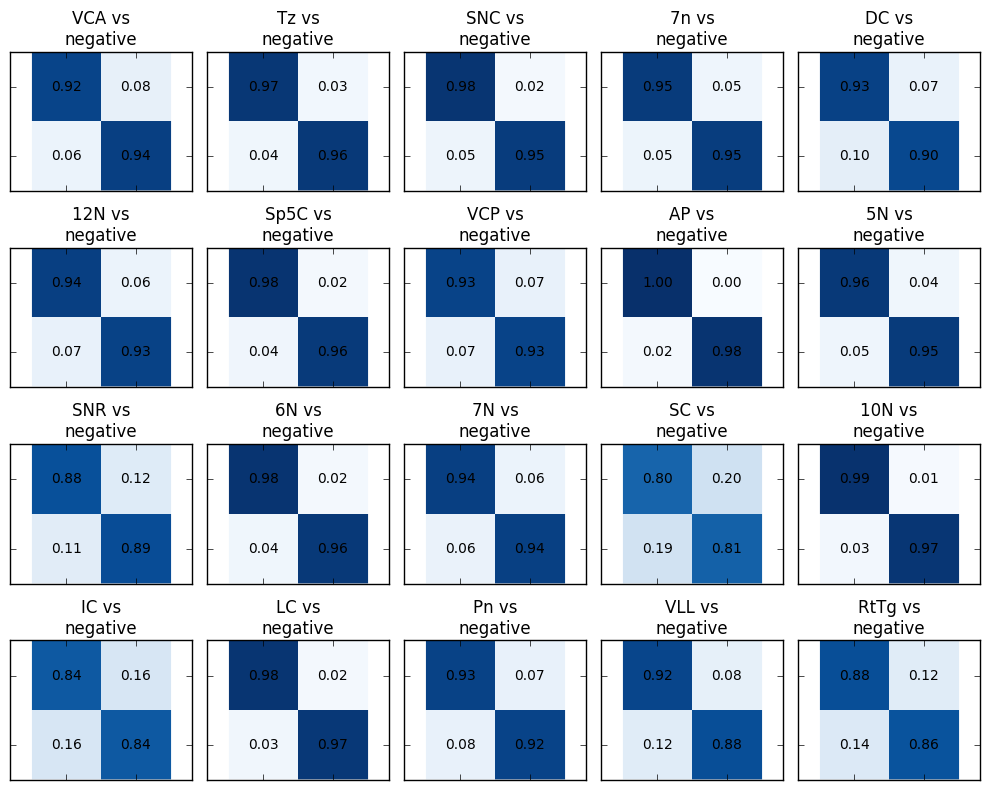

In [66]:
# Compute test accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))


fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = test_features[label]
    n_pos = len(features_pos)
    
#     features_neg = test_features[convert_to_surround_name(label)]
    
#     if train_sample_scheme in [1,3,4,5,6,7]:
#         features_neg = test_features[convert_to_surround_name(label, 'noclass')]
#     elif train_sample_scheme == 2:
#         features_neg = np.vstack([test_features[convert_to_surround_name(label, 'noclass')]] + \
#                                   [test_features[convert_to_surround_name(label, surr_l)] 
#                                   for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
# #     elif train_sample_scheme == 8:
    features_neg = test_features[label + '_negative']
    n_neg = len(features_neg)
#         features_neg = test_features['7N']
#     else:
#         sys.stderr.write('training scheme is not recognized.\n')
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    plot_confusion_matrix(cm, title='%(label)s vs\nnegative'% {'label':label},
                          labels=['',''], xlabel='', ylabel='',
                         axis=axes[i])
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc
    
plt.tight_layout()

In [67]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.929764825148


In [70]:
single_vs_negative_cm_plot_fp = os.path.join(plots_dir, 'single_vs_negative_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

# Compute x vs. noclass accuracy

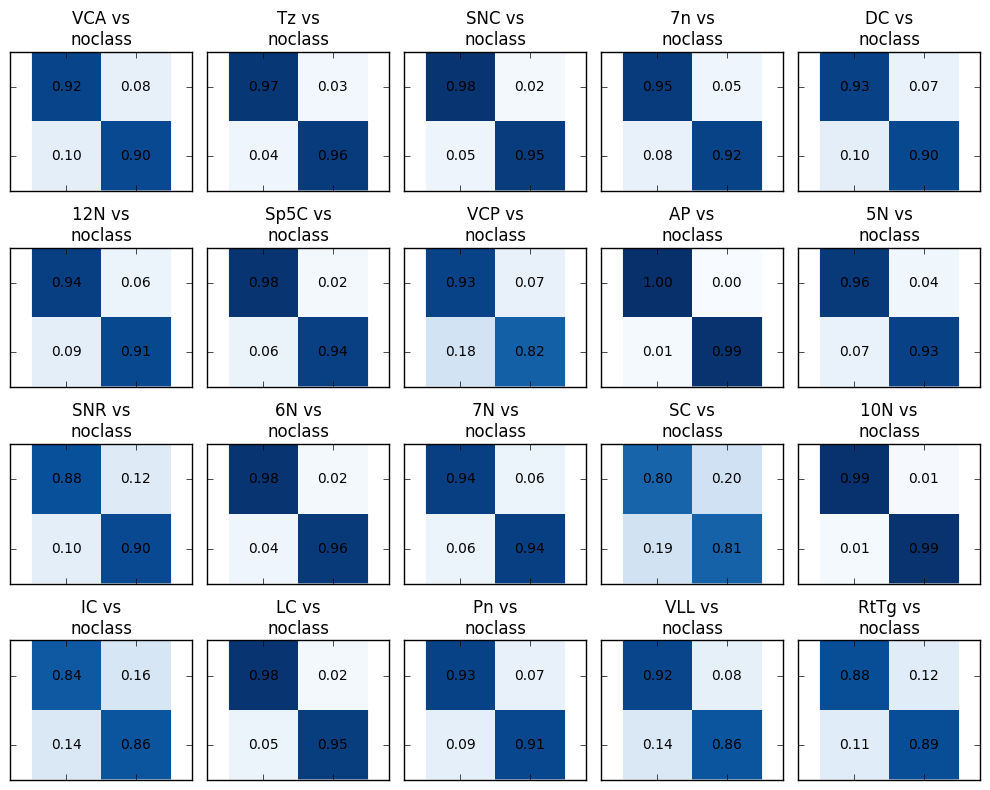

In [71]:
# Compute test accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))


fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = test_features[label]
    n_pos = len(features_pos)
    
#     features_neg = test_features[convert_to_surround_name(label)]
    
#     if train_sample_scheme in [1,3,4,5,6,7]:
#         features_neg = test_features[convert_to_surround_name(label, 'noclass')]
#     elif train_sample_scheme == 2:
#         features_neg = np.vstack([test_features[convert_to_surround_name(label, 'noclass')]] + \
#                                   [test_features[convert_to_surround_name(label, surr_l)] 
#                                   for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
# #     elif train_sample_scheme == 8:
    features_neg = test_features['noclass']
    n_neg = len(features_neg)
#         features_neg = test_features['7N']
#     else:
#         sys.stderr.write('training scheme is not recognized.\n')
        
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    plot_confusion_matrix(cm, title='%(label)s vs\nnoclass'% {'label':label},
                          labels=['',''], xlabel='', ylabel='',
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc
    
plt.tight_layout()

In [72]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.923504954448


In [73]:
single_vs_noclass_cm_plot_fp = os.path.join(plots_dir, 'single_vs_noclass_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute surround accuracy

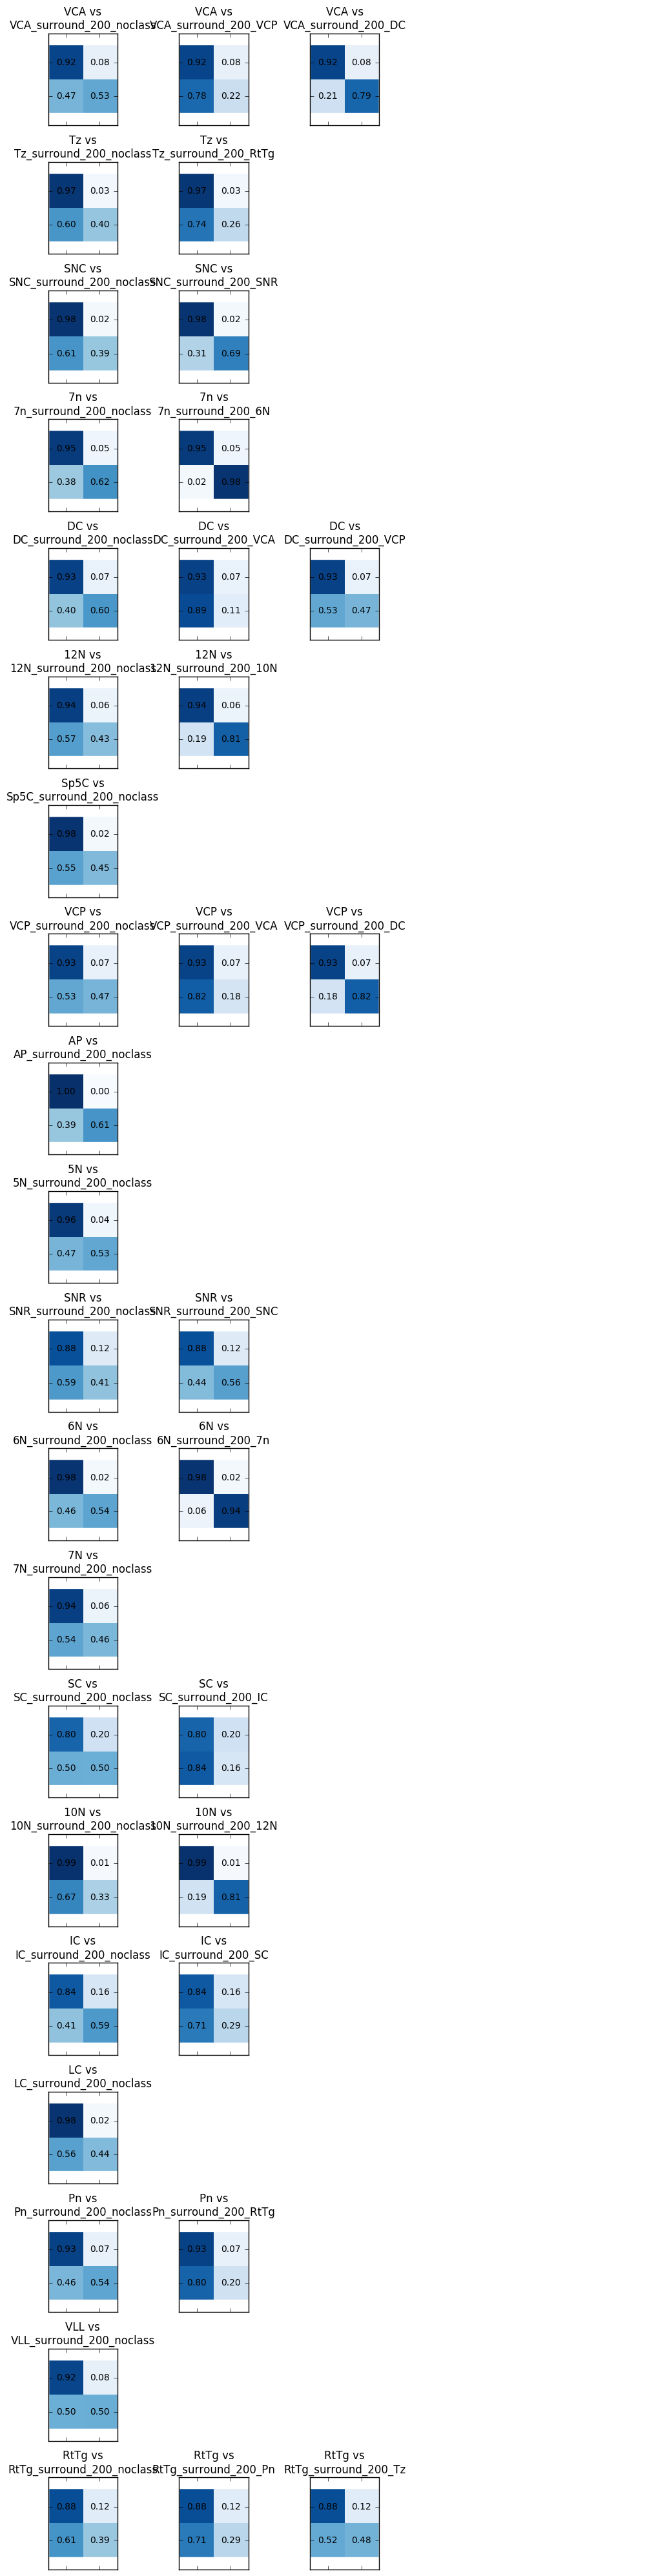

In [84]:
# Compute surround accuracy

margin = 200
acc_all_pairs = {}

ncols = 5
nrows = len(existing_names)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)

for i, label in enumerate(existing_names):
#     print label

    features_pos = test_features[label]
    n_pos = len(features_pos)

    neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(label, margin=margin, suffix=surr_l) 
     for surr_l in structures if convert_to_surround_name(label, margin=margin, suffix=surr_l) in labels]

    for j, neg_class in enumerate(neg_classes):
#         print 'comparing with', neg_class

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        svc = svc_allClasses[label]

        probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)
        
        plot_confusion_matrix(cm, title='%(label)s vs\n%(neg_class)s'% {'label':label, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])
        
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                      normalize=False)
        acc = (cm[0,0]+cm[1,1]) / (n_pos+n_neg)
        acc_all_pairs['%(label)s vs %(neg_class)s'% {'label':label, 'neg_class': neg_class}] = acc


    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [85]:
surround_cm_plot_fp = os.path.join(plots_dir, 'surround_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [90]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('SC vs SC_surround_200_IC', 0.48094249431090397),
 ('IC vs IC_surround_200_SC', 0.56490056094559271),
 ('RtTg vs RtTg_surround_200_noclass', 0.63497510804312018),
 ('SNR vs SNR_surround_200_noclass', 0.64187306936122412),
 ('SC vs SC_surround_200_noclass', 0.64766714369621514),
 ('10N vs 10N_surround_200_noclass', 0.65922579119671376),
 ('SNC vs SNC_surround_200_noclass', 0.67831172094875436),
 ('Tz vs Tz_surround_200_noclass', 0.68251725894189852),
 ('12N vs 12N_surround_200_noclass', 0.6867957209503458),
 ('6N vs 6N_surround_200_noclass', 0.68809133190362359),
 ('RtTg vs RtTg_surround_200_Pn', 0.68997344337623323),
 ('VCP vs VCP_surround_200_VCA', 0.6911388658480131),
 ('VCP vs VCP_surround_200_noclass', 0.69764139225802868),
 ('7N vs 7N_surround_200_noclass', 0.6986518308340387),
 ('Pn vs Pn_surround_200_RtTg', 0.70070681326201611),
 ('VLL vs VLL_surround_200_noclass', 0.70880062787199793),
 ('LC vs LC_surround_200_noclass', 0.70968266409688208),
 ('Sp5C vs Sp5C_surround_200_nocla

# Compute surround accuracy for different margins

In [77]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in [100,200,300,400,500,600,700,800,900,1000]:
    
    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, label in enumerate(existing_names):
    #     print label

        features_pos = test_features[label]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(label, margin=margin, suffix=surr_l) for surr_l in structures if convert_to_surround_name(label, margin=margin, suffix=surr_l) in labels]

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]
            
            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            svc = svc_allClasses[label]

            probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(label)s vs %(neg_class)s'% {'label':label, 'neg_class': neg_class}] = acc
            
    acc_all_margins[margin] = acc_all_pairs

margin = 100
margin = 200
margin = 300
margin = 400
margin = 500
margin = 600
margin = 700
margin = 800
margin = 900
margin = 1000


In [78]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

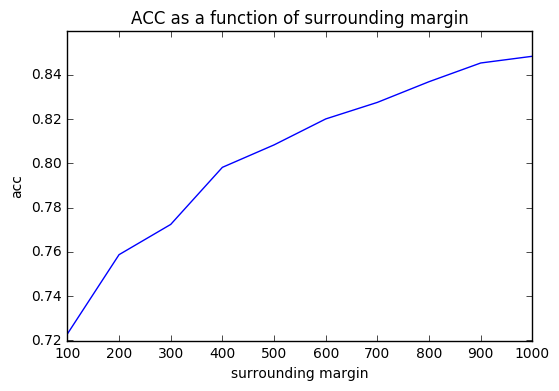

In [79]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute pairwise accuracy

In [57]:
# Compute pairwise accuracy

pairwise_cm = np.zeros((len(existing_names), len(existing_names)))

# for i, label in enumerate(structures):
# axes_id = 0
for i, label in enumerate(sorted(list(existing_names))):
    print i, label
    
    features_pos = test_features[label]
    n_pos = len(features_pos)
        
    for j, label2 in enumerate(sorted(list(existing_names))):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
        print 'comparing with', j, label2
        
        features_neg = test_features[label2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        svc = svc_allClasses[label]

        probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

0 10N
comparing with 1 12N
comparing with 2 5N
comparing with 3 6N
comparing with 4 7N
comparing with 5 7n
comparing with 6 AP
comparing with 7 DC
comparing with 8 IC
comparing with 9 LC
comparing with 10 Pn
comparing with 11 RtTg
comparing with 12 SC
comparing with 13 SNC
comparing with 14 SNR
comparing with 15 Sp5C
comparing with 16 Tz
comparing with 17 VCA
comparing with 18 VCP
comparing with 19 VLL
1 12N
comparing with 2 5N
comparing with 3 6N
comparing with 4 7N
comparing with 5 7n
comparing with 6 AP
comparing with 7 DC
comparing with 8 IC
comparing with 9 LC
comparing with 10 Pn
comparing with 11 RtTg
comparing with 12 SC
comparing with 13 SNC
comparing with 14 SNR
comparing with 15 Sp5C
comparing with 16 Tz
comparing with 17 VCA
comparing with 18 VCP
comparing with 19 VLL
2 5N
comparing with 3 6N
comparing with 4 7N
comparing with 5 7n
comparing with 6 AP
comparing with 7 DC
comparing with 8 IC
comparing with 9 LC
comparing with 10 Pn
comparing with 11 RtTg
comparing with 12 SC

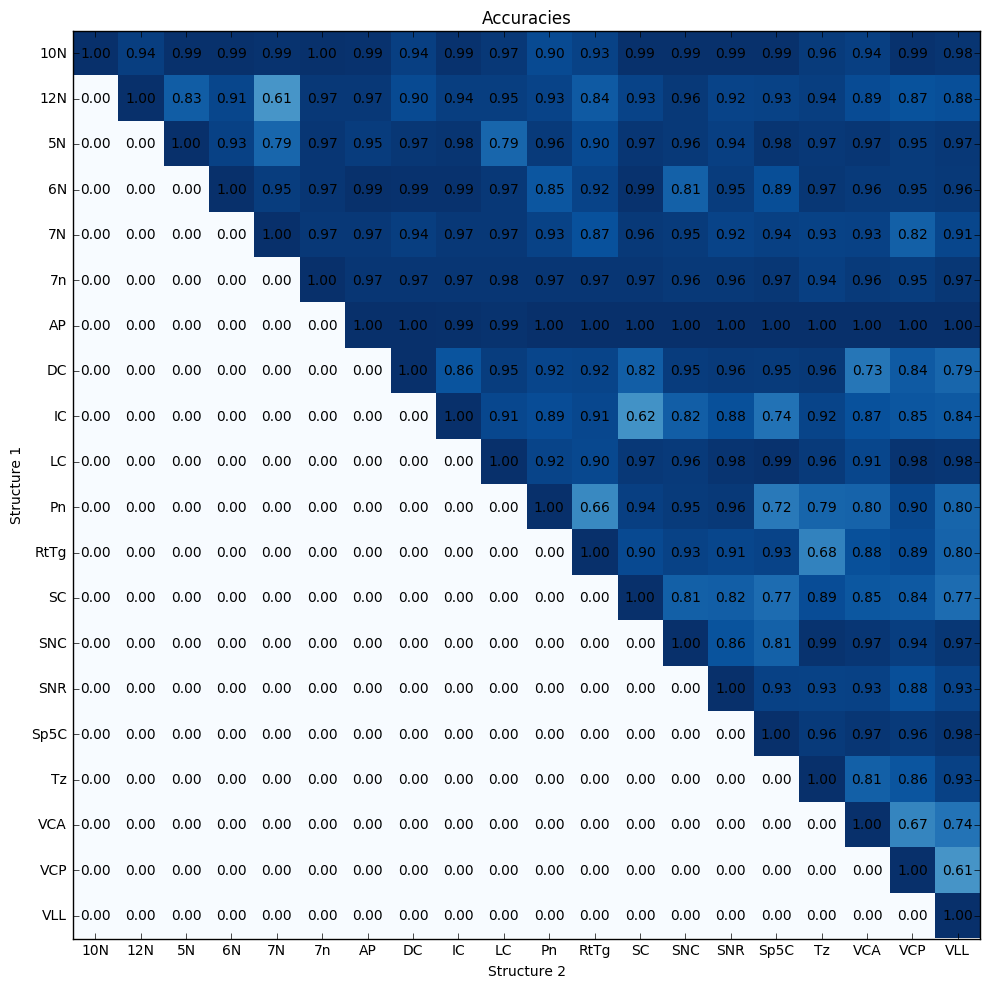

In [58]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=sorted(list(existing_names)),
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [60]:
pariwise_cm_plot_fp = os.path.join(plots_dir, 'pairwise_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')

NameError: name 'plots_dir' is not defined

In [ ]:
# Predict full frame

In [ ]:
stack = 'MD591'

filenames_to_sections, sections_to_filenames = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]
anchor_fn = DataManager.load_anchor_filename(stack)

In [ ]:
def svm_predict(stack, sec):
    fn = sections_to_filenames[sec]
    if fn in ['Nonexisting', 'Rescan', 'Placeholder']:
        return

    feature_fn = PATCH_FEATURES_ROOTDIR + '/%(stack)s/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_features.hdf' % dict(stack=stack, fn=fn, anchor_fn=anchor_fn)
    
    try:
        features = load_hdf(feature_fn)
    except Exception as e:
        sys.stderr.write(e.message + '\n')
        return
    
    output_dir = create_if_not_exists(os.path.join(SPARSE_SCORES_ROOTDIR, stack, '%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped' % \
                                      {'fn': fn, 'anchor_fn': anchor_fn}))
    
    for label in structures:
        svc = svc_allClasses[label]
        probs = svc.predict_proba(features)[:, svc.classes_.tolist().index(1.)]
        output_fn = output_dir + '/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_%(label)s_sparseScores.hdf' % \
                    {'fn': fn, 'anchor_fn': anchor_fn, 'label':label}
        bp.pack_ndarray_file(probs, output_fn)

In [ ]:
t = time.time()
# Parallel(n_jobs=8)(delayed(svm_predict)(stack=stack, sec=sec) for sec in range(first_sec, last_sec+1))
Parallel(n_jobs=8)(delayed(svm_predict)(stack=stack, sec=sec) for sec in range(200, 201))
sys.stderr.write('svm predict: %.2f seconds\n' % (time.time() - t)) # 35 s / 10 section; 863 seconds /stack